<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/examples/mqnhits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1qjiUfddfUolPl_QsFIwP8jN1NSGxnhtS)



## MultiQuantile Neural Hierarchical Interpolation for Time Series 

Making predictions for the future involves varying degrees of imperfect or unknown information that translates into uncertainty. For this reason, probabilistic forecasting has emerged as a natural answer to quantify the uncertainty of the future of the target variable, conditioning on the available information of its predictors.

In this notebok we extend the [N-HiTS](https://arxiv.org/abs/2201.12886) model for the probabilistic forecasting task in long horizon settings, to overcome the limitated information of point forecasting. By combining the N-HiTS model with the multi quantile loss function into the [MQN-HiTS]() model we enable its outputs to produce at any time $t$ a predictive distribution:

$$\mathbb{P}(\mathbf{y}_{t+1:t+H} \;|\; \mathbf{y}_{:t})$$

For the experimental setting we chose the M4-Hourly data and compare against the classic [AutoARIMA](https://github.com/Nixtla/statsforecast) model, using the Multi Quantile Loss (MQLoss).

$$ \mathrm{MQLoss}(y_{\tau}, [\hat{y}^{(q1)}_{\tau},\hat{y}^{(q2)}_{\tau},\dots,\hat{y}^{(Q)}_{\tau}]) = \frac{1}{H} \sum_{q} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) $$

Table of Contents
1.   [Installing NeuralForecast and StatForecast](#cell-1)<br>
  1.1 [Defining Utilities](#cell-1.1)<br>
2.   [Load large M4-Hourly data](#cell-2)<br>
  2.1 [Split Train/Test](#cell-2.1)<br>
  2.2 [Scaling Data](#cell-2.2)<br>
3.   [MQ-NHiTS](#cell-3)<br>
  3.1 [Instantiate MQ-NHiTS](#cell-3.1)<br>
  3.2 [Fit MQ-NHiTS](#cell-3.2)<br>
  3.3 [Plot MQ-NHiTS predictions](#cell-3.3)<br>
4.   [AutoARIMA](#cell-4)<br>
  4.1 [Fit AutoARIMA model](#cell-4.1)<br>
  4.2 [Plot AutoARIMA predictions](#cell-4.2)<br>
5.   [MQ-Loss Evaluation](#cell-5)

If you are interested in the quantile regression and long horizon forecasting literature, take a look at these papers:
- [Regression Quantiles, Econometrica](https://www.jstor.org/stable/1913643)
- [N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting](https://arxiv.org/abs/2201.12886)
- [Neural Multi-Quantile Forecasting for Optimal Inventory Management](https://arxiv.org/abs/2112.05673)



<a name="cell-1"></a>
# 1. Installing NeuralForecast and StatsForecast library

Run `pip install neuralforecast` to install all required dependencies.

In [1]:
%%capture
pip install neuralforecast

In [2]:
%%capture
pip install statsforecast

In [3]:
import datetime
import logging
import random
from itertools import product
from typing import List

import torch as t
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from IPython.display import Image
from neuralforecast.data.datasets.m4 import M4
from neuralforecast.data.tsdataset import WindowsDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import get_mask_dfs
from neuralforecast.models.mqnhits.mqnhits import MQNHITS
from neuralforecast.losses.numpy import mqloss


logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This example will automatically run on GPUs if available. **Make sure** cuda is available. (If you need help to put this into production send us an email or join or community, we also offer a fully hosted solution)

In [4]:
t.cuda.is_available() 
#Should be true

False

<a name="cell-1.1"></a>
## 1.1 Defining utilitites

The class `StandardScaler` defined below helps to standardize a dataframe with multiple time series (removing the mean and scaling to unit variance). It is particularly useful for Deep Learning models, as their performance usually improves with this preprocessing step.

In [5]:
class StandardScaler:
    """This class helps to standardize a dataframe with multiple time series."""
    def __init__(self):
        self.norm: pd.DataFrame
        
    def fit(self, X: pd.DataFrame) -> 'StandardScaler':
        self.norm = X.groupby('unique_id').agg({'y': [np.mean, np.std]})
        self.norm = self.norm.droplevel(0, 1).reset_index()
        
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        transformed = X.merge(self.norm, how='left', on=['unique_id'])
        transformed['y'] = (transformed['y'] - transformed['mean']) / transformed['std']
        return transformed[['unique_id', 'ds', 'y']]
    
    def inverse_transform(self, X: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
        transformed = X.merge(self.norm, how='left', on=['unique_id'])
        for col in cols:
            transformed[col] = transformed[col] * transformed['std'] + transformed['mean']
        return transformed[['unique_id', 'ds'] + cols]

The `plot_grid` function defined below will be useful to plot different time series, and different models' forecasts.

In [6]:
def plot_grid(df_train, df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_5'], c='blue', alpha=0.3)
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_50'], c='blue', label='p50')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y_95'], c='blue', alpha=0.3)
            axes[idx, idy].fill_between(x=test_uid['ds'],
                                        y1=test_uid['y_5'],
                                        y2=test_uid['y_95'],
                                        alpha=0.2, label='p5-p95')
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

<a name="cell-2"></a>
# 2. Load M4-Hourly Data

The `M4` class will automatically download the M4 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series. For this example we will only use `Y_df`.

In [7]:
forecast_horizon = 24
ds_in_val = 24
ds_in_test= 24

In [8]:
%%capture
# Change this to your own data
Y_df, _, _ = M4.load(directory='./', group='Hourly')

ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong downloading data
INFO:neuralforecast.data.datasets.utils:Successfully downloaded Yearly-train.csv, 25355736, bytes.
ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong downloading data
INFO:neuralforecast.data.datasets.utils:Successfully downloaded Yearly-test.csv, 1486434, bytes.
ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong downloading data
INFO:neuralforecast.data.datasets.utils:Successfully downloaded Quarterly-train.csv, 38788547, bytes.
ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong downloading data
INFO:neuralforecast.data.datasets.utils:Successfully downloaded Quarterly-test.csv, 1971754, bytes.
ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong downloading data
INFO:neuralforecast.data.datasets.utils:Successfully downloaded Monthly-train.csv, 91655432, bytes.
ERROR:neuralforecast.data.datasets.utils:ERROR, something went wrong dow

<a name="cell-2.1"></a>
## 2.1 Split train/test sets

In this example, we will use the last `forecast_horizon=24` observations of each time series as test set. Therefore, we will define one set `Y_df_train` and one set `Y_df_test` to ensure that the last observations are not observed during training.

In [9]:
Y_df_test = Y_df.groupby('unique_id').tail(forecast_horizon)
Y_df_train = Y_df.drop(Y_df_test.index)

In [11]:
Y_df_test

,unique_id,ds,y
724,H1,725,635.0
725,H1,726,572.0
726,H1,727,532.0
727,H1,728,493.0
728,H1,729,477.0
...,...,...,...
373367,H99,744,24039.0
373368,H99,745,22946.0
373369,H99,746,22217.0
373370,H99,747,21416.0


In [13]:
Y_df_train

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
373343,H99,720,26274.0
373344,H99,721,25185.0
373345,H99,722,24924.0
373346,H99,723,24075.0


<a name="cell-2.2"></a>
## 2.2 Scaling data

This step standardizes (removes the mean and scales to unit variance) the train set for the `MQN-HiTS` model. The object `scaler` will also help us to transform the forecasts to the original scale once we have them.

In [12]:
scaler = StandardScaler()
scaler.fit(Y_df_train)

In [14]:
Y_df_train_scaled = scaler.transform(Y_df_train)

The following plot shows random time series.

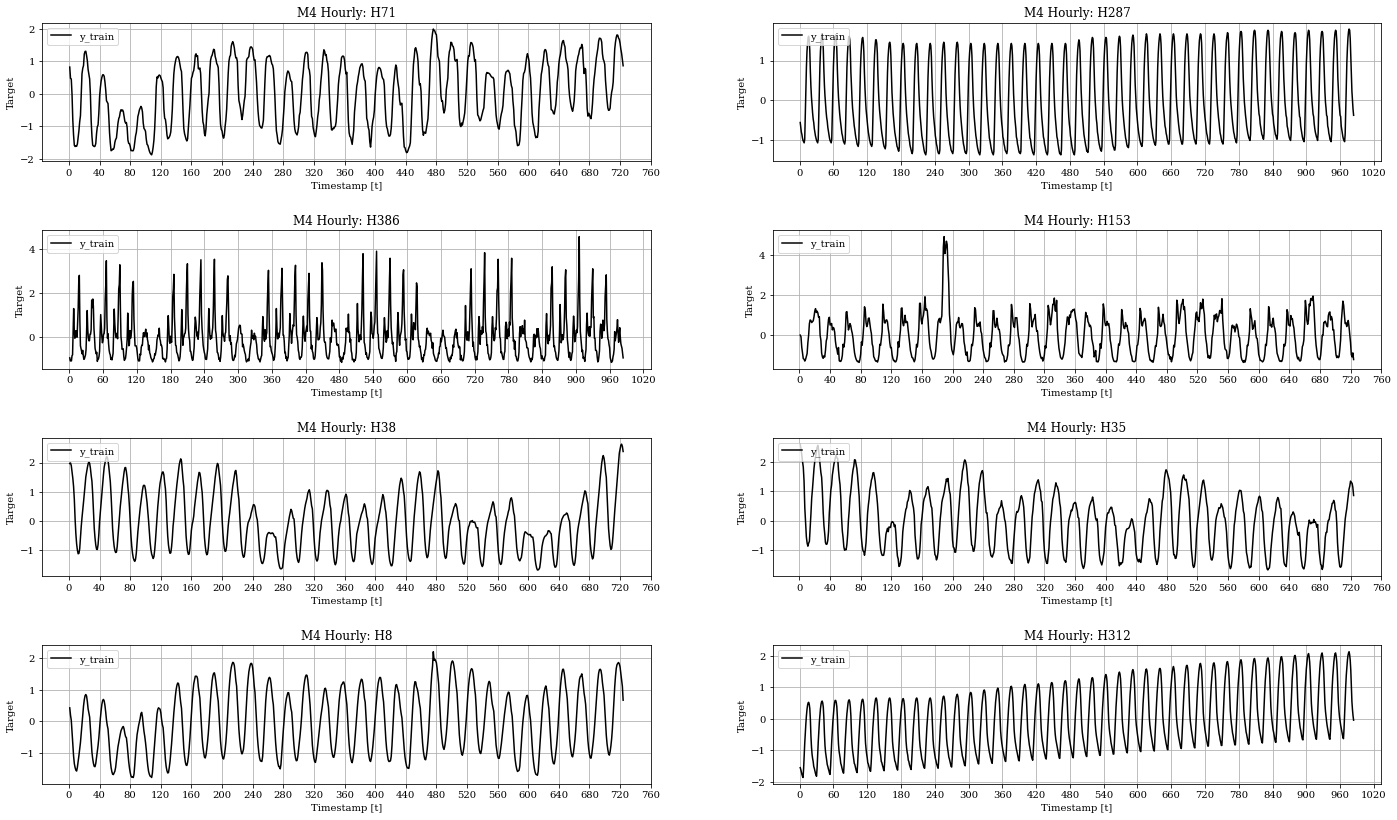

In [15]:
plot_grid(Y_df_train_scaled)

<a name="cell-3"></a>
# 3. MQN-HiTS

The N-HiTS model incorporates hierarchical interpolation and multi-rate data sampling techniques. It assembles its predictions sequentially, selectively emphasizing components with different frequencies and scales while decomposing the input signal and synthesizing the forecast. Here we extend N-HiTS into [MQN-HiTS](), allowing it to produce probabilistic predictions with the Multi-Quantile Loss.

To instantiate your [MQN-HiTS]() model and adapt it for your use, you can play around with its hyperparameters.

As mentioned earlier the quantile loss can extend modularly any neural forecasting algorithm into a non parametric quantile regressor. The resulting quantile regression has several advantageous properties, it is robust to outliers, it does not depend on the selection of a probability family and it has theoretical convergence guarantees to the distribution governing the time series process, see [Regression Quantiles, Econometrica](https://www.jstor.org/stable/1913643).

<img src="https://drive.google.com/uc?export=view&id=1_rOOwPQUDohHKISiycEFLJpGTrt8yIp4" 
     width="600" 
     height="300" />

<a name="cell-3.1"></a>
## 3.1 Instantiate Model

In [16]:
model = MQNHITS(n_time_in=3*forecast_horizon,    # number of input lags
                n_time_out=forecast_horizon,     # forecasting horizon
                quantiles=[5, 50, 95],           # quantiles for MQ-LOSS
                shared_weights=False,            # shared parameters between blocks in each stack
                initialization='lecun_normal',   # initialization
                activation='ReLU',               # activation function
                stack_types=3*['identity'],      # list of stack types (only 'identity' type its supported)
                n_blocks=3*[1],                  # number of blocks in each stack
                n_layers=3*[2],                  # number of layers in MLP of each block
                n_mlp_units=3*[2*[256]],         # number of units (nodes) in each layer
                n_pool_kernel_size=3*[1],        # Pooling kernel size for input downsampling for each stack
                n_freq_downsample=[12,4,1],      # Inverse of expresivity ratio. Output size of stack i is (H/n_freq_downsample_i)
                pooling_mode='max',              # Pooling mode
                interpolation_mode='linear',     # Interpolation mode
                batch_normalization=False,       # Batch normalization in MLP
                dropout_prob_theta=0,            # Dropout probability
                learning_rate=0.001,
                lr_decay=1.0,
                lr_decay_step_size=100_000,
                weight_decay=0.0,
                loss_train='MQ',
                loss_valid='MQ',
                frequency='H',
                n_x=0,
                n_s=0,
                n_x_hidden=0,
                n_s_hidden=0,
                loss_hypar=0.5,
                random_seed=1)

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpp2npevop
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpp2npevop/_remote_module_non_sriptable.py


<a name="cell-3.2"></a>
## 3.2 Fit MQN-HiTS

Here we define the train dataloader and the Pytorch Lightning trainer with which we will pre-train the [MQN-HiTS]() model.

In [17]:
train_mask_df, valid_mask_df, _ = get_mask_dfs(Y_df=Y_df_train_scaled,
                                               ds_in_val=ds_in_val,
                                               ds_in_test=0)

In [18]:
train_dataset = WindowsDataset(Y_df=Y_df_train_scaled, X_df=None, S_df=None, 
                               mask_df=train_mask_df, f_cols=[],
                               input_size=3*forecast_horizon,
                               output_size=forecast_horizon,
                               sample_freq=1,
                               complete_windows=True,
                               verbose=False)

valid_dataset = WindowsDataset(Y_df=Y_df_train_scaled, X_df=None, S_df=None, 
                               mask_df=valid_mask_df, f_cols=[],
                               input_size=3*forecast_horizon,
                               output_size=forecast_horizon,
                               sample_freq=1,
                               complete_windows=True,
                               verbose=False)

train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                n_windows=1024,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=1,
                                shuffle=False)

gpus = -1 if t.cuda.is_available() else 0
trainer = pl.Trainer(max_epochs=None, 
                     max_steps=1000,
                     gradient_clip_val=1.0,
                     progress_bar_refresh_rate=1,
                     check_val_every_n_epoch=50,
                     gpus=gpus,
                     log_every_n_steps=1)

trainer.fit(model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
Missing logger folder: /content/lightning_logs


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:682: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

<a name="cell-3.3"></a>
## 3.3 Plot MQN-HiTS predictions

In [19]:
%%capture
forecasts_mqnhits = model.forecast(Y_df_train_scaled)

INFO:root:Train Validation splits

INFO:root:                                       ds                              
                                      min                           max
sample_mask                                                            
0           1970-01-01 00:00:00.000000001 1970-01-01 00:00:00.000000984
1           1970-01-01 01:00:00.000000984 1970-01-02 00:00:00.000000984
INFO:root:
Total data 			373372 time stamps 
Available percentage=100.0, 	373372 time stamps 
Insample  percentage=2.66, 	9936 time stamps 
Outsample percentage=97.34, 	363436 time stamps 



In [20]:
forecasts_mqnhits['ds'] = Y_df_test['ds'].values

In [21]:
forecasts_mqnhits.head()

,unique_id,ds,y_5,y_50,y_95
0,H1,725,-0.204204,-0.013925,0.050442
1,H1,726,-0.579890,-0.457491,-0.334249
2,H1,727,-0.877433,-0.724094,-0.660568
3,H1,728,-1.081845,-0.908851,-0.791460
4,H1,729,-1.170129,-1.031444,-0.908417


In [22]:
forecasts_mqnhits = scaler.inverse_transform(forecasts_mqnhits, ['y_5', 'y_50', 'y_95'])

In [23]:
forecasts_mqnhits = forecasts_mqnhits.merge(Y_df_test, how='left', on=['unique_id', 'ds'])

In [24]:
forecasts_mqnhits['ds'] = forecasts_mqnhits['ds'].astype(int)

In [26]:
Y_df_train

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0
...,...,...,...
373343,H99,720,26274.0
373344,H99,721,25185.0
373345,H99,722,24924.0
373346,H99,723,24075.0


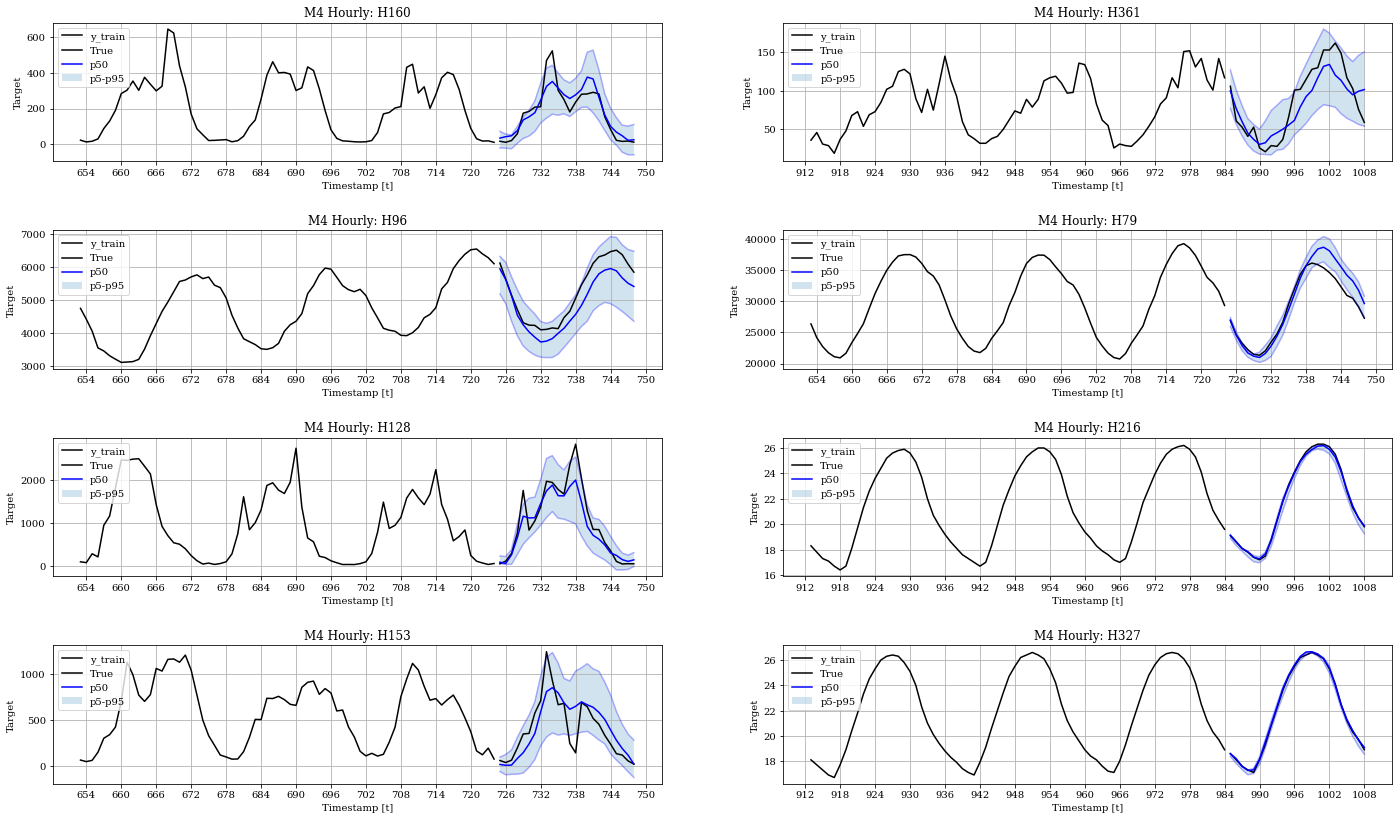

In [25]:
plot_grid(Y_df_train.groupby('unique_id').tail(3*forecast_horizon), forecasts_mqnhits)

<a name="cell-4"></a>
# 4. Auto-ARIMA

[AutoARIMA]() is one of the most widely used models for time series forecasting. The model focuses on leveraging autocorrelations to obtain accurate predictions and constitutes a well-proven model that works great for baselines. It has been an industry standard for its speed and accuracy.

This AutoARIMA was developed by [Hyndman and Khandakar](https://otexts.com/fpp3/arima-r.html) to optimize three parameters using the AIC criterion:
- The number of autoregressive terms p
- The number of differences d
- The number of moving average parameters q

In [27]:
from statsforecast import StatsForecast
from statsforecast.models import auto_arima

<a name="cell-4.1"></a>
## 4.1 Fit AutoARIMA

In this example, we limit the `input_size` of the `AutoARIMA` model to `3*forecast_horizon` to make results against `MQN-HiTS` comparable.

In [28]:
%%capture
fcst = StatsForecast(Y_df_train[['unique_id', 'ds', 'y']].groupby('unique_id').tail(3*forecast_horizon).set_index('unique_id'),
                     models=[(auto_arima, 24)],
                     freq='H', n_jobs=-1)
forecasts_autoarima = fcst.forecast(forecast_horizon, level=[90]).reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for auto_arima_season_length-24.


In [29]:
forecasts_autoarima.head()

,unique_id,ds,auto_arima_season_length-24_mean,auto_arima_season_length-24_lo-90,auto_arima_season_length-24_hi-90
0,H1,725,665.648987,629.092896,702.205078
1,H1,726,619.930786,544.918274,694.943298
2,H1,727,579.282898,452.269012,706.296875
3,H1,728,543.039124,359.021301,727.057007
4,H1,729,510.624146,267.834076,753.414246


In [30]:
forecasts_autoarima = forecasts_autoarima.rename(columns={
    'auto_arima_season_length-24_lo-90': 'y_5',
    'auto_arima_season_length-24_mean': 'y_50',
    'auto_arima_season_length-24_hi-90': 'y_95'
})

In [31]:
forecasts_autoarima = forecasts_autoarima.merge(Y_df_test, how='left', on=['unique_id', 'ds'])

In [32]:
forecasts_autoarima['ds'] = forecasts_autoarima['ds'].astype(int)

<a name="cell-4.2"></a>
## 4.2 Plot AutoARIMA predictions

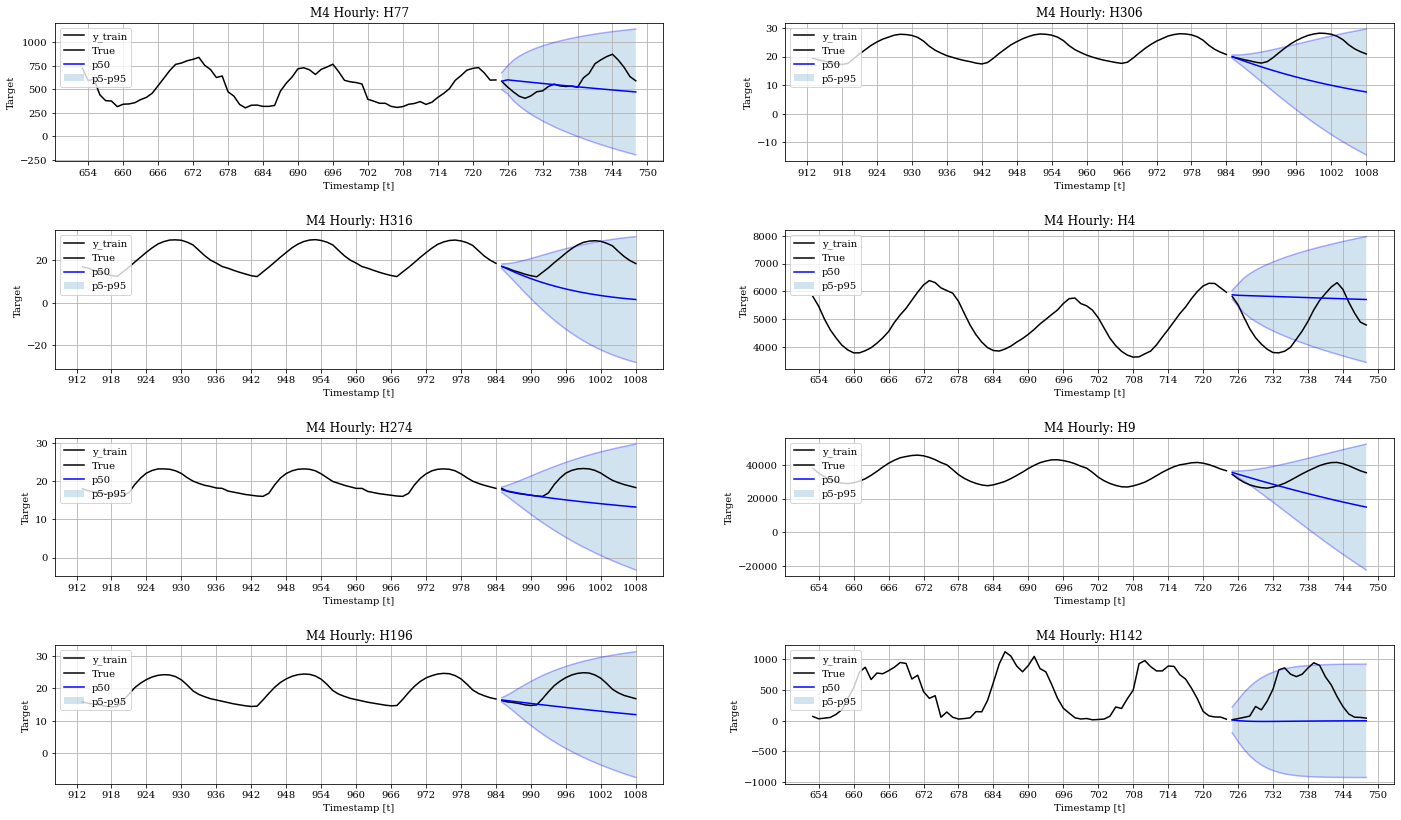

In [33]:
plot_grid(Y_df_train.groupby('unique_id').tail(3*forecast_horizon), forecasts_autoarima)

<a name="cell-5"></a>
# 5. MQ-Loss Evaluation

For the evaluation we use the Multi Quantile Loss:

$$ \mathrm{MQLoss}(y_{\tau}, [\hat{y}^{(q1)}_{\tau},\hat{y}^{(q2)}_{\tau},\dots,\hat{y}^{(Q)}_{\tau}]) = \frac{1}{H} \sum_{q} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) $$

In [34]:
eval_cols = ['y_5', 'y_50', 'y_95']
mqnhits_loss = mqloss(y=Y_df_test['y'].values.reshape(-1, forecast_horizon), 
                      y_hat=forecasts_mqnhits[eval_cols].values.reshape(-1, forecast_horizon, 3), 
                      quantiles=np.array([0.05,0.5,0.95]))
arima_loss = mqloss(y=Y_df_test['y'].values.reshape(-1, forecast_horizon),
                    y_hat=forecasts_autoarima[eval_cols].values.reshape(-1, forecast_horizon, 3),
                    quantiles=np.array([0.05,0.5,0.95]))

In [35]:
print('MQN-HiTS:  \t\t {0:.4f}'.format(mqnhits_loss))
print('ARIMA:     \t\t {0:.4f}'.format(arima_loss))

MQN-HiTS:  		 54.5876
ARIMA:     		 831.6060
